# Week 4: OLS Demand Model

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import pickle

import os
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib 
# import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.ticker import MultipleLocator

### load competition data and show some stats

In [2]:
df_comp_details = pd.read_csv('duopoly_competition_details.csv')
df_comp_details.fillna(0, inplace=True)

df_comp_details['revenue'] = df_comp_details['price'] * df_comp_details['demand']

df_comp_details.head(3)

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors,revenue
0,3A3gcX,1,1,AttentiveOriole,55.5,33.5,0,True,0.009,0.0,0.0
1,3A3gcX,1,2,AttentiveOriole,33.5,31.8,1,True,0.015,0.0,31.8
2,3A3gcX,1,3,AttentiveOriole,31.8,30.2,0,True,0.002,0.0,0.0


In [3]:
df_comp_details['unique_selling_season_key'] = df_comp_details.apply(lambda r:
                                "%s_%s" % (r.competition_id,r.selling_season), axis=1)

In [4]:
dfx_rev = df_comp_details.groupby('unique_selling_season_key').agg({
    'revenue' : 'sum'
}).reset_index()
dfx_rev.head(3)

,unique_selling_season_key,revenue
0,3A3gcX_1,803.2
1,3A3gcX_10,745.1
2,3A3gcX_100,748.6


# Let us build our own demand model based on the competition data.

## => f(price, competitor_price) = demand

## idea:
- split selling_season into sub-intervals where we assume a constant demand model
    - e.g. selling period [1,20] assumed to have almost constant demand
- estimate the demand model per competition
- train on first 50 selling_seasons and evaluate on the last 50

3A3gcX


<Axes: >

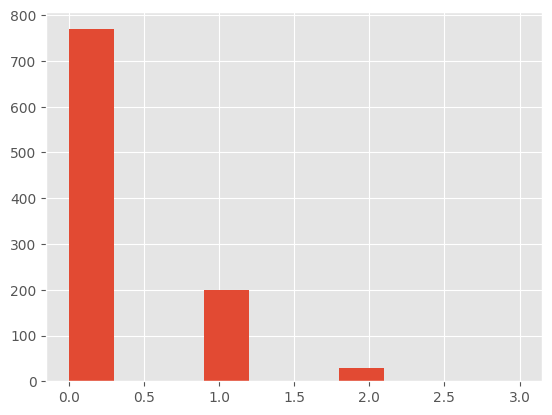

In [5]:
comp = df_comp_details.competition_id.unique()[0]
print(comp)

# filter on first competion_id
df = df_comp_details[df_comp_details.competition_id==comp ]

# concentrate on selling period in [1,20]
df = df[df.selling_period <= 20 ]

df_train = df[df.selling_season<=50]
df_test = df[df.selling_season>50]

df_train.demand.hist()

Text(0, 0.5, 'Count')

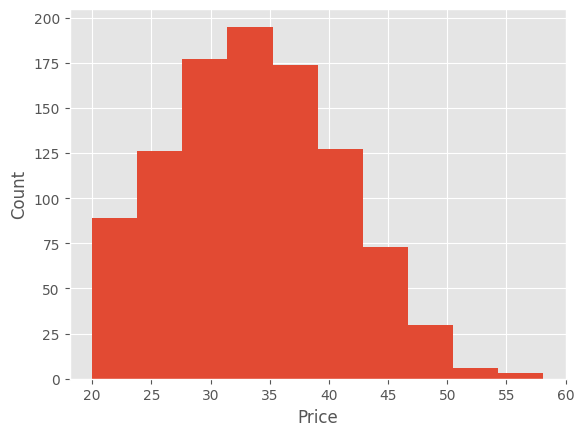

In [6]:
# df_train.head(35)
# df_train.demand.hist()
df_train.price.hist()
plt.xlabel('Price')
plt.ylabel('Count')


Text(0, 0.5, 'Count')

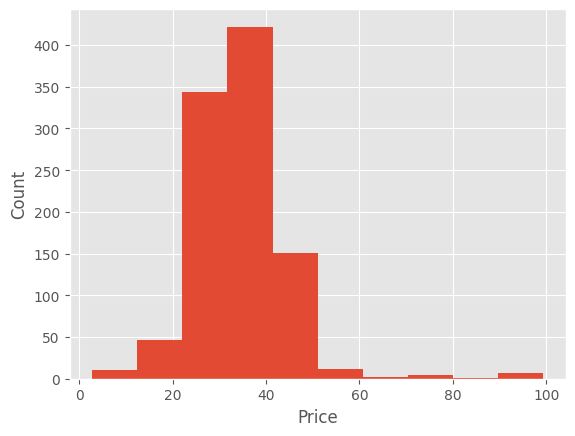

In [7]:
df_train.price_competitor.hist()
plt.xlabel('Price')
plt.ylabel('Count')

## (a) fit OLS model

In [17]:
import statsmodels.api as sm
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

y = df_train.demand

X = df_train[['price', 'price_competitor']]
X['intercept'] = 1


mod = sm.OLS(y, X)
# mod = sm.regression.quantile_regression.QuantReg(y,X)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     21.82
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           5.33e-10
Time:                        13:28:58   Log-Likelihood:                -723.66
No. Observations:                1000   AIC:                             1453.
Df Residuals:                     997   BIC:                             1468.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
price               -0.0140      0.003  

## (b) predict demand based on function for
- own price = 30
- competitor price = 50

In [23]:
mod.predict(res.params, [30,50,1])

np.float64(0.528897922345403)

In [24]:
print(res.params)

price              -0.014019
price_competitor    0.013735
intercept           0.262726
dtype: float64


## (c) simulate demand, our prices in [1,100] and competitor_price = 50

In [25]:
def est_demand(price, comp_price, para = res.params):
    demand = para["intercept"] + price*para["price"]+comp_price*para["price_competitor"]
    demand = max(0,demand)
    return demand

df_sim = pd.DataFrame(columns = ['price','demand','rev'])
for p in np.arange(1,100,1):
    demand = est_demand(p,10)
    rev = demand*p
    df_sim.loc[len(df_sim)] = [p,demand,rev]

    
df_sim.head()

,price,demand,rev
0,1.0,0.386057,0.386057
1,2.0,0.372038,0.744075
2,3.0,0.358018,1.074055
3,4.0,0.343999,1.375996
4,5.0,0.329980,1.649899


#### plot demand and revenue curve

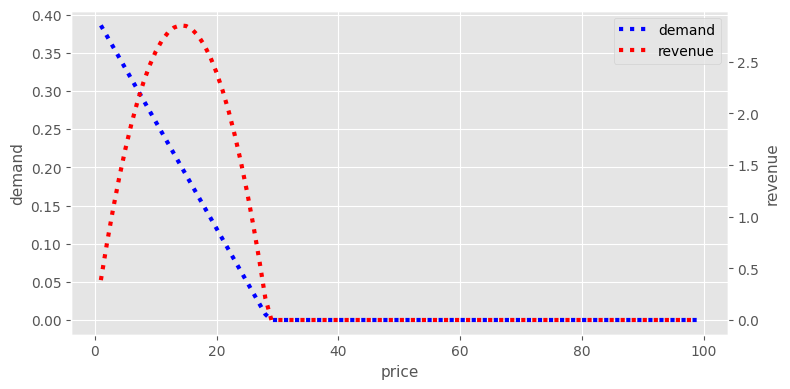

In [26]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df_sim['price'], df_sim['demand'], color='b', 
        linestyle='dotted', linewidth=3, label='demand')

ax_2 = ax.twinx()
ax_2.grid(False)
ax_2.plot(df_sim['price'], df_sim['rev'], color='r', 
        linestyle='dotted', linewidth=3, label='revenue')

ax_2.tick_params(axis="both", labelsize=10)
ax.tick_params(axis="both", labelsize=10)

# legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_2.get_legend_handles_labels()
ax_2.legend(lines + lines2, labels + labels2, loc=0)

ax.set_xlabel('price', size=11)
ax.set_ylabel("demand" , size=11)
ax_2.set_ylabel("revenue" , size=11)

ax.grid(True)
fig.tight_layout()

plt.show()

## (d) compute estimated demand in computation details

In [27]:
df_eval = df_test[['unique_selling_season_key','selling_season','selling_period','price_competitor', 'price', 'demand']]

df_eval.head(5)

,unique_selling_season_key,selling_season,selling_period,price_competitor,price,demand
5000,3A3gcX_51,51,1,23.6,33.1,0
5001,3A3gcX_51,51,2,33.1,31.4,1
5002,3A3gcX_51,51,3,31.4,29.9,0
5003,3A3gcX_51,51,4,29.9,28.4,2
5004,3A3gcX_51,51,5,28.4,29.5,0


In [28]:
# estimate demand
df_eval['est_demand'] = df_eval.apply(lambda r:
            est_demand(price=r['price'], comp_price=r["price_competitor"]),
            axis=1)

# compute error metrics (error = predicted - actual)
df_eval['est_error'] = df_eval['est_demand'] -  df_eval['demand']
df_eval['abs_est_error'] = df_eval['est_error'].abs()

df_eval.head(5)

,unique_selling_season_key,selling_season,selling_period,price_competitor,price,demand,est_demand,est_error,abs_est_error
5000,3A3gcX_51,51,1,23.6,33.1,0,0.122833,0.122833,0.122833
5001,3A3gcX_51,51,2,33.1,31.4,1,0.277149,-0.722851,0.722851
5002,3A3gcX_51,51,3,31.4,29.9,0,0.274828,0.274828,0.274828
5003,3A3gcX_51,51,4,29.9,28.4,2,0.275255,-1.724745,1.724745
5004,3A3gcX_51,51,5,28.4,29.5,0,0.239231,0.239231,0.239231


In [29]:
df_eval[['demand', 'est_demand', 'est_error', 'abs_est_error']].describe()

,demand,est_demand,est_error,abs_est_error
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.268000,0.269468,0.001468,0.401973
std,0.520045,0.100817,0.518774,0.327695
min,0.000000,0.000000,-2.725408,0.000000
25%,0.000000,0.272669,0.037853,0.273474
50%,0.000000,0.276708,0.273943,0.278082
75%,0.000000,0.279692,0.278446,0.392933
max,3.000000,1.066666,1.066666,2.725408


### plot the actual demand vs. estimated demand for one test selling season

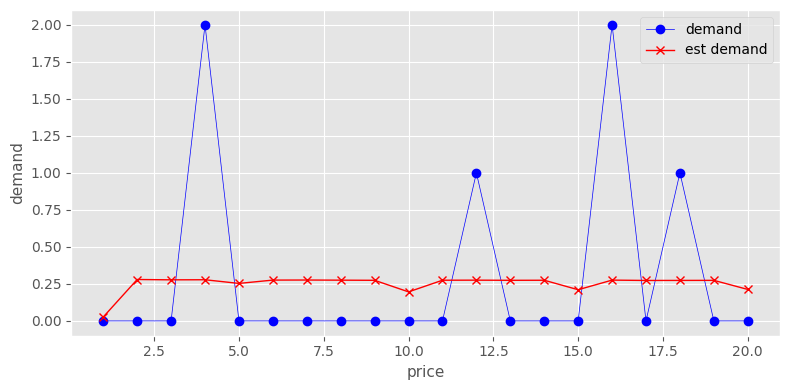

In [30]:
dfe = df_eval[df_eval.selling_season==80]

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(dfe['selling_period'], dfe['demand'], color='b', 
        linestyle='-', marker='o', linewidth=0.5, markersize=6, label='demand')

ax.plot(dfe['selling_period'], dfe['est_demand'], color='r', 
        linestyle='-', marker='x', linewidth=1, markersize=6, label='est demand')

ax.legend( loc=0)

ax.set_xlabel('price', size=11)
ax.set_ylabel("demand" , size=11)

ax.grid(True)
fig.tight_layout()

plt.show()

# next tasks:
## (1) estimate five demand models covering the 100 period selling_season
## (2) estimate demand models for every simulation_id 
## (3) implement the demand model in your own simulation (last week simulation notebook)
## (4) implement the demand model estimation & next price optimization in your pricing algorithm